In [3]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

2.5.1
CUDA available: True
GPU name: NVIDIA GeForce RTX 4090


In [5]:
!pip install torch torchvision
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ================================
# Paths (update if needed)
# ================================
base_dir = r"C:\Users\Ruijia Li\Downloads\archive"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
meta_dir = os.path.join(base_dir, "meta")

# ================================
# Transforms
# ================================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ================================
# Dataset & Dataloader
# ================================
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ================================
# CNN Model
# ================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# ================================
# Model Setup
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ================================
# Training Loop
# ================================
print("Start training")
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# ================================
# Save the model
# ================================
torch.save(model.state_dict(), "simple_cnn_model.pth")
print("Training complete and model saved.")


Start training
Epoch 1/5, Loss: 0.5602
Epoch 2/5, Loss: 0.0763
Epoch 3/5, Loss: 0.0474
Epoch 4/5, Loss: 0.0332
Epoch 5/5, Loss: 0.0314
Training complete and model saved.


In [6]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image

# =========================
# Paths
# =========================
train_dir = r"C:\Users\Ruijia Li\Downloads\archive\train"
test_csv = r"C:\Users\Ruijia Li\Downloads\archive\Test.csv"
model_path = "simple_cnn_model.pth"

# =========================
# Transform
# =========================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# =========================
# Load training data to get class mapping
# =========================
train_dataset = datasets.ImageFolder(train_dir)
class_to_idx = train_dataset.class_to_idx      # e.g. {'0': 0, '1': 1, ..., '42': 42}
idx_to_class = {v: k for k, v in class_to_idx.items()}  # reverse mapping

num_classes = len(class_to_idx)

# =========================
# Your CNN model
# =========================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# =========================
# Load model
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# =========================
# Load Test.csv
# =========================
test_df = pd.read_csv(test_csv)

# =========================
# Predict + Accuracy
# =========================
correct = 0
total = 0

with torch.no_grad():
    for _, row in test_df.iterrows():
        path = row["Path"]                   # e.g., Test/00001.png
        raw_label = str(row["ClassId"])      # e.g., '16'
        true_label = class_to_idx.get(raw_label, None)  # Convert to model index

        if true_label is None:
            continue  # skip unknown class

        # Full image path
        image_path = os.path.join(r"C:\Users\Ruijia Li\Downloads\archive", path)

        if not os.path.exists(image_path):
            continue

        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        output = model(input_tensor)
        pred_label = torch.argmax(output, dim=1).item()

        total += 1
        if pred_label == true_label:
            correct += 1

accuracy = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {accuracy:.2f}% ({correct}/{total})")


C:\Users\Ruijia Li\AppData\Local\Temp\ipykernel_6856\2628976350.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio


✅ Final Test Accuracy: 93.21% (11773/12630)


C:\Users\Ruijia Li\AppData\Local\Temp\ipykernel_6856\4200672736.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

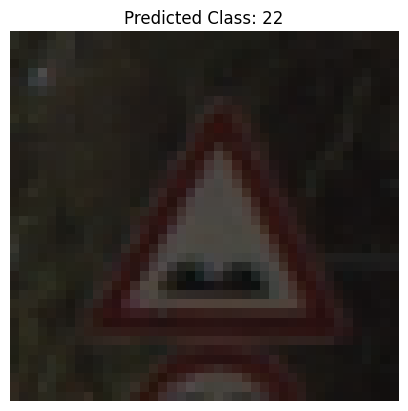

✅ Predicted class for '04854.png': 22


In [7]:
!pip install matplotlib
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets

# =========================
# Paths
# =========================
train_dir = r"C:\Users\Ruijia Li\Downloads\archive\train"
test_dir = r"C:\Users\Ruijia Li\Downloads\archive\test"
model_path = "simple_cnn_model.pth"

# =========================
# Image Transform
# =========================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# =========================
# Load train dataset to get class mapping
# =========================
train_dataset = datasets.ImageFolder(train_dir)
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

# =========================
# Define your CNN model
# =========================
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(128 * 16 * 16, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# =========================
# Load the model
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# =========================
# Pick a random test image
# =========================
test_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
random_image_name = random.choice(test_images)
random_image_path = os.path.join(test_dir, random_image_name)

# Load and preprocess the image
image = Image.open(random_image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    output = model(input_tensor)
    predicted_index = torch.argmax(output, dim=1).item()
    predicted_label = idx_to_class[predicted_index]

# =========================
# Display the result
# =========================
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_label}")
plt.show()

print(f"✅ Predicted class for '{random_image_name}': {predicted_label}")



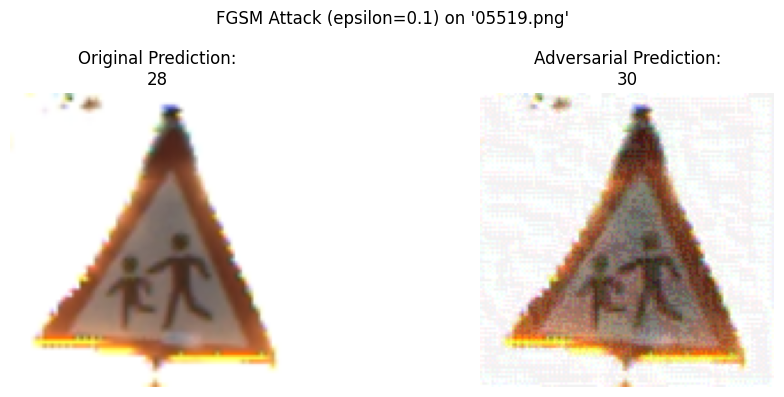

⚠️  Adversarial attack successful! Changed from '28' to '30'


In [18]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# =========================
# FGSM function
# =========================
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

# =========================
# Select random image
# =========================
test_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_image_name = random.choice(test_images)
random_image_path = os.path.join(test_dir, random_image_name)

# Load and preprocess image
image = Image.open(random_image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)
input_tensor.requires_grad = True

# =========================
# Predict original
# =========================
output = model(input_tensor)
orig_pred_idx = output.argmax(1).item()
orig_pred_label = idx_to_class[orig_pred_idx]

# Assume original prediction is correct label
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(output, torch.tensor([orig_pred_idx], device=device))
model.zero_grad()
loss.backward()
data_grad = input_tensor.grad.data

# =========================
# Create adversarial image
# =========================
epsilon = 0.1
adv_tensor = fgsm_attack(input_tensor, epsilon, data_grad)

# =========================
# Predict adversarial
# =========================
with torch.no_grad():
    adv_output = model(adv_tensor)
    adv_pred_idx = adv_output.argmax(1).item()
    adv_pred_label = idx_to_class[adv_pred_idx]

# =========================
# Convert for plotting
# =========================
def im_convert(tensor):
    img = tensor.squeeze().detach().cpu().numpy()
    img = img.transpose(1, 2, 0)
    img = img * 0.5 + 0.5  # Unnormalize
    return np.clip(img, 0, 1)

# =========================
# Show both images
# =========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(im_convert(input_tensor))
ax1.set_title(f"Original Prediction:\n{orig_pred_label}")
ax1.axis('off')

ax2.imshow(im_convert(adv_tensor))
ax2.set_title(f"Adversarial Prediction:\n{adv_pred_label}")
ax2.axis('off')

plt.suptitle(f"FGSM Attack (epsilon={epsilon}) on '{random_image_name}'")
plt.tight_layout()
plt.show()

# =========================
# Print result
# =========================
if orig_pred_label != adv_pred_label:
    print(f"⚠️  Adversarial attack successful! Changed from '{orig_pred_label}' to '{adv_pred_label}'")
else:
    print(f"✅ Model still predicted '{orig_pred_label}' after FGSM attack")


▶️ FGSM on a random test image


C:\Users\Ruijia Li\AppData\Local\Temp\ipykernel_6856\3069034469.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

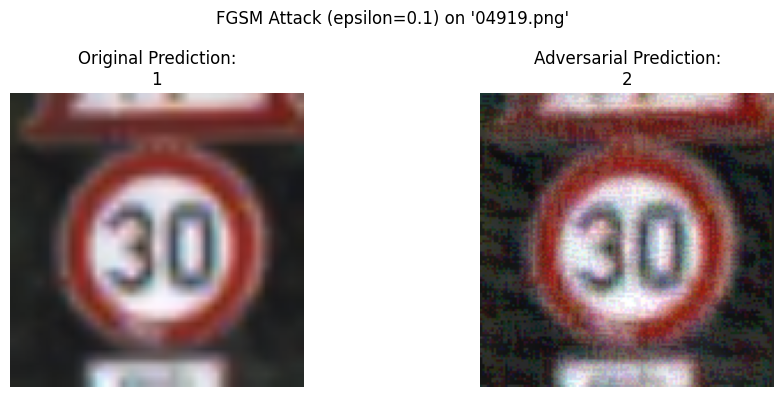

⚠️ Attack successful: changed from '1' to '2'

▶️ Evaluating FGSM attack on all test images...

=== FGSM Evaluation Report ===
Total Images Evaluated: 12630
Original Accuracy: 0.9321
Adversarial Accuracy: 0.2216
Predictions Changed: 9831 / 12630 (77.84%)
📉 Accuracy dropped by 0.7105 due to FGSM.


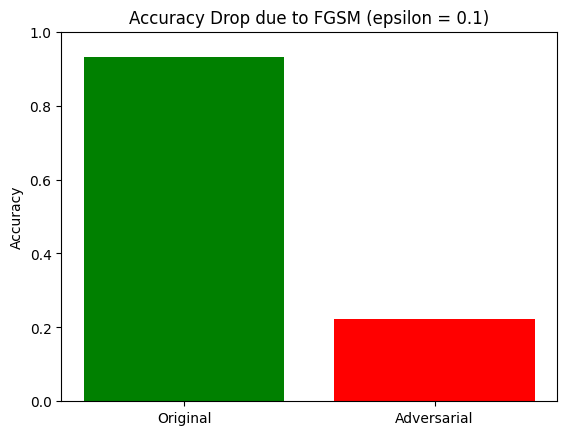

In [23]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms, datasets

# =========================
# Paths and model config
# =========================
train_dir = r"C:\Users\Ruijia Li\Downloads\archive\train"
test_dir = r"C:\Users\Ruijia Li\Downloads\archive\test"
model_path = "simple_cnn_model.pth"

# =========================
# Image Transform
# =========================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# =========================
# Load train dataset for class mapping
# =========================
train_dataset = datasets.ImageFolder(train_dir)
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

# =========================
# Define CNN Model
# =========================
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(128 * 16 * 16, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# =========================
# Load the model
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# =========================
# FGSM Function
# =========================
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

# =========================
# Convert Tensor to Displayable Image
# =========================
def im_convert(tensor):
    img = tensor.squeeze().detach().cpu().numpy()
    img = img.transpose(1, 2, 0)
    img = img * 0.5 + 0.5  # Unnormalize
    return np.clip(img, 0, 1)

# =========================
# PART 1: Visualize FGSM on One Random Image
# =========================
def visualize_random_fgsm(epsilon=0.1):
    print("▶️ FGSM on a random test image")

    test_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    random_image_name = random.choice(test_images)
    random_image_path = os.path.join(test_dir, random_image_name)

    image = Image.open(random_image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    output = model(input_tensor)
    orig_pred_idx = output.argmax(1).item()
    orig_pred_label = idx_to_class[orig_pred_idx]

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, torch.tensor([orig_pred_idx], device=device))
    model.zero_grad()
    loss.backward()
    data_grad = input_tensor.grad.data

    adv_tensor = fgsm_attack(input_tensor, epsilon, data_grad)
    with torch.no_grad():
        adv_output = model(adv_tensor)
        adv_pred_idx = adv_output.argmax(1).item()
        adv_pred_label = idx_to_class[adv_pred_idx]

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.imshow(im_convert(input_tensor))
    ax1.set_title(f"Original Prediction:\n{orig_pred_label}")
    ax1.axis('off')

    ax2.imshow(im_convert(adv_tensor))
    ax2.set_title(f"Adversarial Prediction:\n{adv_pred_label}")
    ax2.axis('off')

    plt.suptitle(f"FGSM Attack (epsilon={epsilon}) on '{random_image_name}'")
    plt.tight_layout()
    plt.show()

    if orig_pred_label != adv_pred_label:
        print(f"⚠️ Attack successful: changed from '{orig_pred_label}' to '{adv_pred_label}'")
    else:
        print(f"✅ Attack failed: still '{orig_pred_label}'")

# =========================
# PART 2: Evaluate FGSM on All Test Images
# =========================
def evaluate_fgsm_on_all_images(test_dir, model, transform, idx_to_class, epsilon=0.1):
    print("\n▶️ Evaluating FGSM attack on all test images...")
    model.eval()
    test_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    total = 0
    correct_adversarial = 0
    changed = 0

    criterion = torch.nn.CrossEntropyLoss()

    for img_name in test_images:
        img_path = os.path.join(test_dir, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            continue

        input_tensor = transform(image).unsqueeze(0).to(device)
        input_tensor.requires_grad = True

        output = model(input_tensor)
        orig_pred_idx = output.argmax(1).item()

        loss = criterion(output, torch.tensor([orig_pred_idx], device=device))
        model.zero_grad()
        loss.backward()
        data_grad = input_tensor.grad.data
        adv_tensor = fgsm_attack(input_tensor, epsilon, data_grad)

        with torch.no_grad():
            adv_output = model(adv_tensor)
            adv_pred_idx = adv_output.argmax(1).item()

        total += 1
        if adv_pred_idx == orig_pred_idx:
            correct_adversarial += 1
        else:
            changed += 1

    # Use actual original accuracy: 11773 / 12630 = 93.21%
    original_accuracy = 11773 / 12630
    acc_adversarial = correct_adversarial / total
    drop = original_accuracy - acc_adversarial

    print("\n=== FGSM Evaluation Report ===")
    print(f"Total Images Evaluated: {total}")
    print(f"Original Accuracy: {original_accuracy:.4f}")
    print(f"Adversarial Accuracy: {acc_adversarial:.4f}")
    print(f"Predictions Changed: {changed} / {total} ({(changed / total) * 100:.2f}%)")
    print(f"📉 Accuracy dropped by {drop:.4f} due to FGSM.")

    # Bar plot
    plt.bar(['Original', 'Adversarial'], [original_accuracy, acc_adversarial], color=['green', 'red'])
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Drop due to FGSM (epsilon = {epsilon})")
    plt.ylim(0, 1)
    plt.show()

# =========================
# Run both parts
# =========================
epsilon = 0.1  # You can change this to test different strengths
visualize_random_fgsm(epsilon=epsilon)
evaluate_fgsm_on_all_images(test_dir, model, transform, idx_to_class, epsilon=epsilon)



▶️ Evaluating FGSM metrics across multiple epsilon values...
ε=0.00 | Accuracy: 1.0000 | Fooling: 0.0000 | ConfDrop: 0.0000
ε=0.01 | Accuracy: 0.6125 | Fooling: 0.3875 | ConfDrop: 0.3592
ε=0.03 | Accuracy: 0.3890 | Fooling: 0.6110 | ConfDrop: 0.5821
ε=0.05 | Accuracy: 0.3036 | Fooling: 0.6964 | ConfDrop: 0.6678
ε=0.10 | Accuracy: 0.2216 | Fooling: 0.7784 | ConfDrop: 0.7506
ε=0.20 | Accuracy: 0.1557 | Fooling: 0.8443 | ConfDrop: 0.8158
ε=0.30 | Accuracy: 0.1277 | Fooling: 0.8723 | ConfDrop: 0.8438


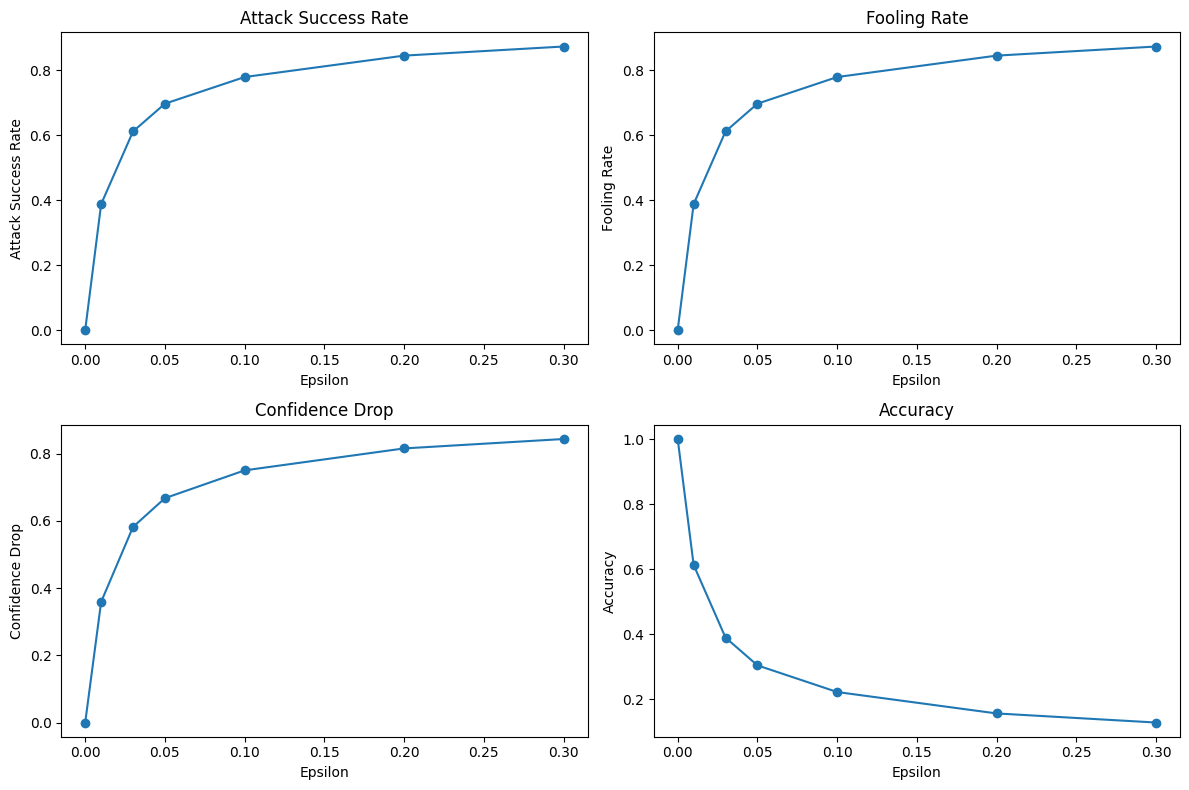

In [26]:
def run_fgsm_metrics_across_epsilons(epsilon_values, test_dir, model, transform, idx_to_class):
    print("\n▶️ Evaluating FGSM metrics across multiple epsilon values...")

    test_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    original_accuracy = 11773 / 12630

    acc_list = []
    fooling_rate_list = []
    attack_success_list = []
    confidence_drop_list = []

    criterion = torch.nn.CrossEntropyLoss()

    for epsilon in epsilon_values:
        correct = 0
        fooled = 0
        total = 0
        confidence_drop = []

        for img_name in test_images:
            img_path = os.path.join(test_dir, img_name)

            try:
                image = Image.open(img_path).convert("RGB")
            except:
                continue

            input_tensor = transform(image).unsqueeze(0).to(device)
            input_tensor.requires_grad = True

            output = model(input_tensor)
            orig_pred_idx = output.argmax(1).item()
            orig_confidence = torch.softmax(output, dim=1)[0][orig_pred_idx].item()

            loss = criterion(output, torch.tensor([orig_pred_idx], device=device))
            model.zero_grad()
            loss.backward()
            data_grad = input_tensor.grad.data

            adv_tensor = fgsm_attack(input_tensor, epsilon, data_grad)
            with torch.no_grad():
                adv_output = model(adv_tensor)
                adv_pred_idx = adv_output.argmax(1).item()
                adv_confidence = torch.softmax(adv_output, dim=1)[0][orig_pred_idx].item()

            total += 1
            if adv_pred_idx == orig_pred_idx:
                correct += 1
            else:
                fooled += 1

            confidence_drop.append(orig_confidence - adv_confidence)

        acc = correct / total
        fooling_rate = fooled / total
        attack_success = fooled / total
        avg_conf_drop = np.mean(confidence_drop)

        acc_list.append(acc)
        fooling_rate_list.append(fooling_rate)
        attack_success_list.append(attack_success)
        confidence_drop_list.append(avg_conf_drop)

        print(f"ε={epsilon:.2f} | Accuracy: {acc:.4f} | Fooling: {fooling_rate:.4f} | ConfDrop: {avg_conf_drop:.4f}")

    # Plot results
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].plot(epsilon_values, attack_success_list, marker='o')
    axs[0, 0].set_title('Attack Success Rate')
    axs[0, 0].set_xlabel('Epsilon')
    axs[0, 0].set_ylabel('Attack Success Rate')

    axs[0, 1].plot(epsilon_values, fooling_rate_list, marker='o')
    axs[0, 1].set_title('Fooling Rate')
    axs[0, 1].set_xlabel('Epsilon')
    axs[0, 1].set_ylabel('Fooling Rate')

    axs[1, 0].plot(epsilon_values, confidence_drop_list, marker='o')
    axs[1, 0].set_title('Confidence Drop')
    axs[1, 0].set_xlabel('Epsilon')
    axs[1, 0].set_ylabel('Confidence Drop')

    axs[1, 1].plot(epsilon_values, acc_list, marker='o')
    axs[1, 1].set_title('Accuracy')
    axs[1, 1].set_xlabel('Epsilon')
    axs[1, 1].set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

epsilon_values = [0.0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3]
run_fgsm_metrics_across_epsilons(epsilon_values, test_dir, model, transform, idx_to_class)